In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from scipy.stats import skewnorm

from utils import *

In [2]:
model = AutoEncoder(in_channels=1)
model.load_state_dict(torch.load('trained_models/auto_encoder.pt', map_location=torch.device('cpu')))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3)

In [3]:
# Get latent variable
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)
test_data = gen.get_full_data_set(training=False)

x_test, y_test = test_data

# Convert y_train and y_test into one-hot vectors
y_test = to_one_hot(y_test)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

First, show some reconstructions

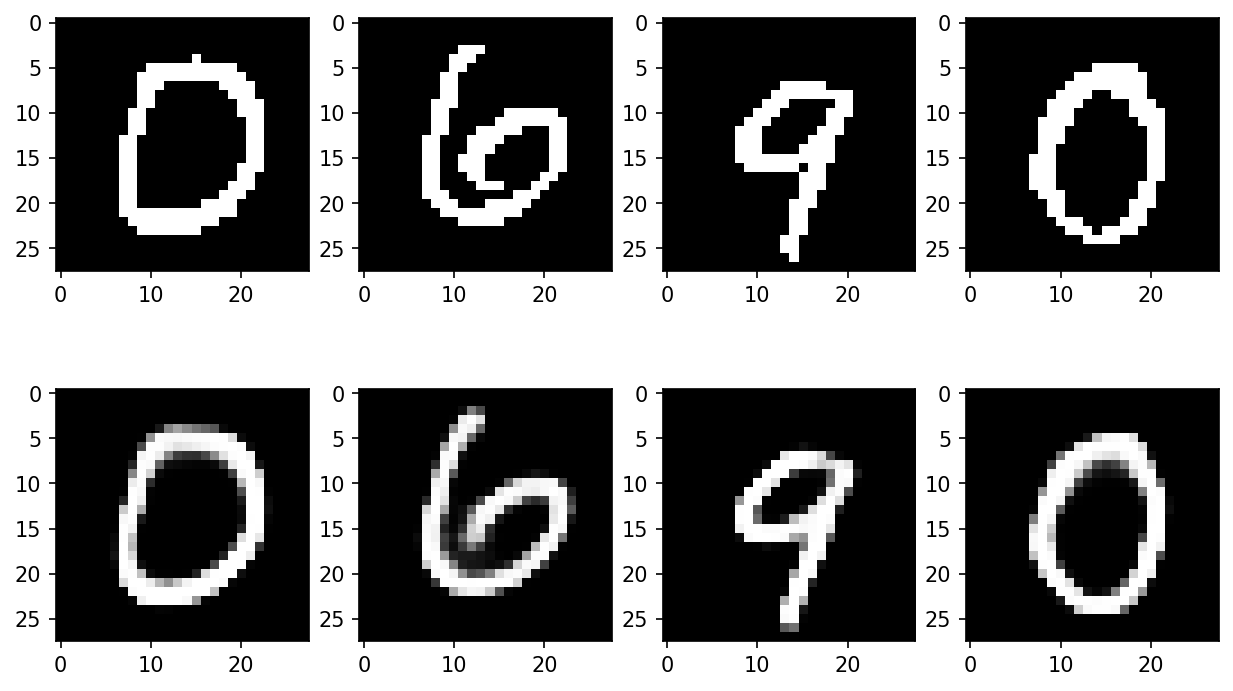

In [4]:
model.eval()

with torch.no_grad():

    x_show, y_show = next(iter(test_loader))

    reconstrustions = model(x_show)

    fig, axs = plt.subplots(2, 4, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(2):
        for j in range(4):
            if i == 0:
                axs[i, j].imshow(x_show[j+10].squeeze(), cmap='gray')
            elif i == 1:
                axs[i, j].imshow(reconstrustions[j+10].squeeze(), cmap='gray')
        
    plt.show()

Now, let's generate an image

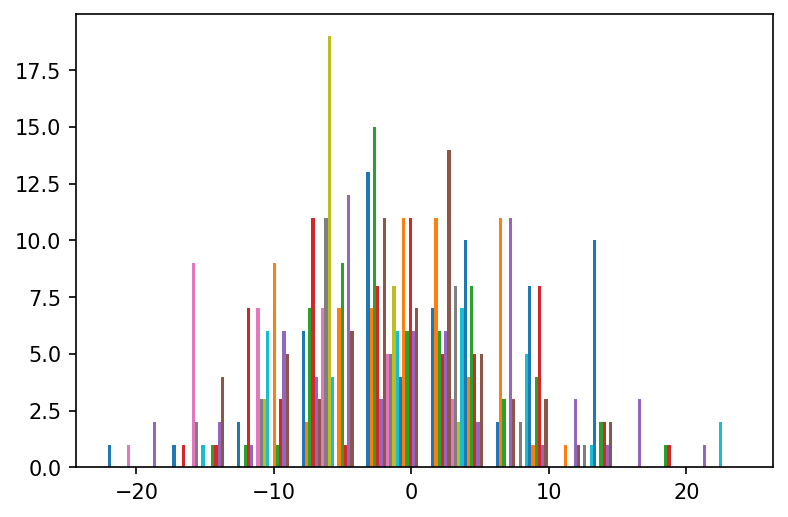

In [5]:
images, _ = next(iter(test_loader))
latent = model.encoder(images)

mean = latent.mean(dim=0)
std = (latent-mean).pow(2).mean(dim=0).sqrt()

z = torch.randn(32, 16) * std + mean
#z = torch.normal(0, 1, size=(32, 16))

plt.figure(figsize=(6, 4), dpi=150)
plt.hist(z.detach().numpy())
plt.show()

In [6]:
model.eval()
with torch.no_grad():
    generated_images = model.decoder(z)

In [7]:
generated_images.shape

torch.Size([32, 1, 28, 28])

In [8]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3)

In [9]:
z = model.decoder[0:5](z)

c1 = model.decoder[5](z)
c1 = F.relu(c1)

c2 = model.decoder[7](c1)
c2 = F.relu(c2)

c3 = model.decoder[9](c2)
c3 = F.relu(c3)


c4 = model.decoder[11](c3)
c4 = F.relu(c4)


c1.shape, c2.shape, c3.shape, c4.shape


(torch.Size([32, 64, 4, 4]),
 torch.Size([32, 32, 7, 7]),
 torch.Size([32, 16, 14, 14]),
 torch.Size([32, 1, 28, 28]))

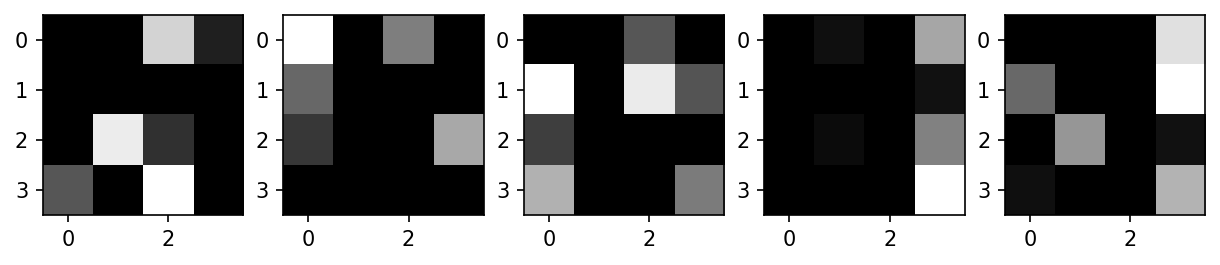

In [10]:
# Visualize som feature maps from c1
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c1[0][i], cmap='gray')
        
    plt.show()

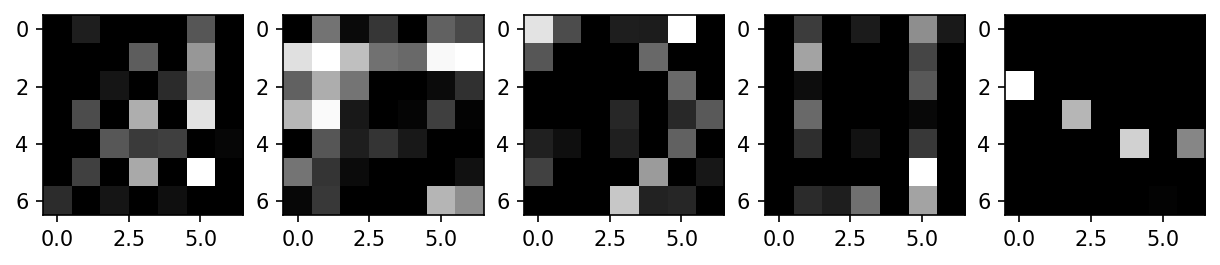

In [11]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c2[0][i], cmap='gray')
        
    plt.show()

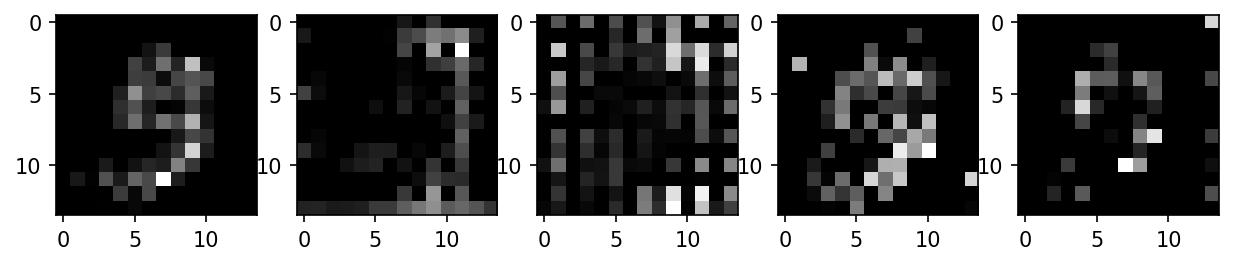

In [12]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c3[0][i], cmap='gray')
        
    plt.show()

C:\Users\mikke\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


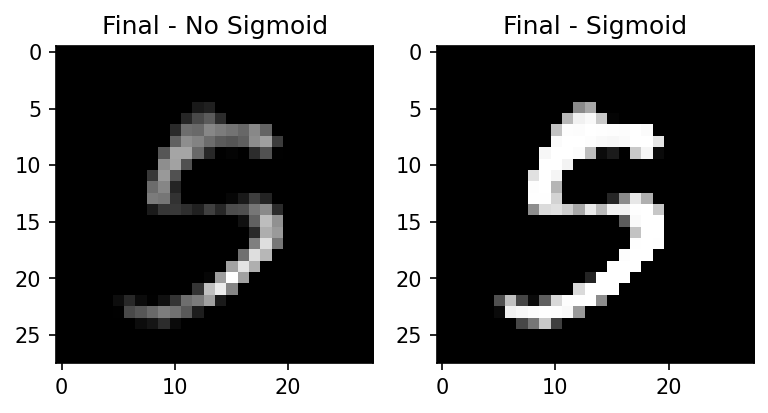

In [13]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

    # Plot each image in a separate subplot
    axs[0].imshow(c4[0].squeeze(0), cmap='gray')
    axs[0].set_title('Final - No Sigmoid')
    axs[1].imshow(F.sigmoid(c4[0].squeeze(0)), cmap='gray')
    axs[1].set_title('Final - Sigmoid')

        
    plt.show()
    

Some more generated images

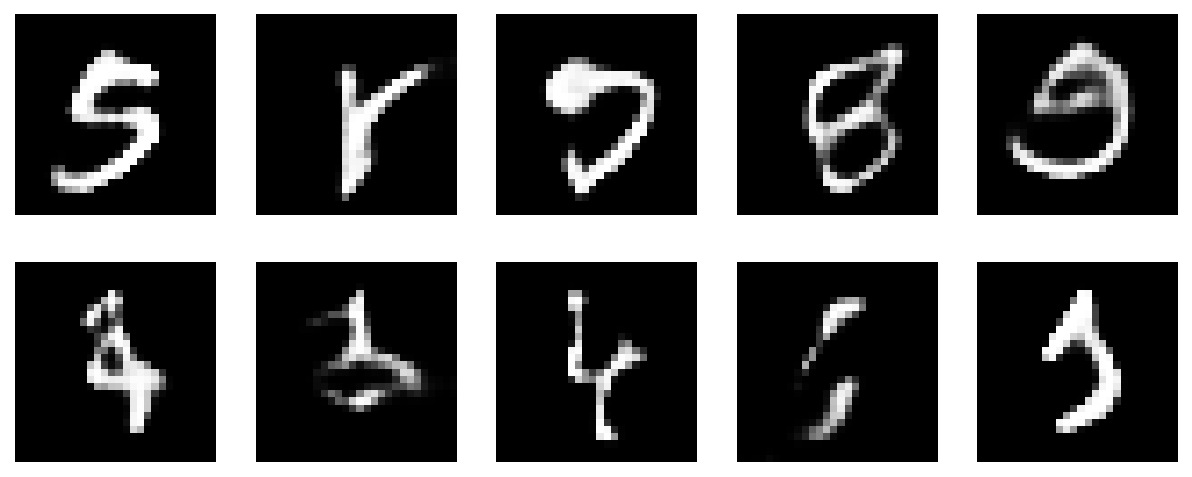

In [14]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(2, 5, figsize=(10, 4), dpi=150)

    n = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(generated_images[n].squeeze(), cmap="gray")
            axs[i, j].axis("off")
            n += 1

        
    plt.show()